### Imports

In [1]:
import re
import nltk
import spacy
import gensim
import logging
import warnings
import pyLDAvis
import numpy as np
import pandas as pd
import pyLDAvis.gensim
import gensim.corpora as corpora



from pprint import pprint
from collections import OrderedDict
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from wordcloud import WordCloud, STOPWORDS 
from spacy.lang.en.stop_words import STOP_WORDS
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
warnings.filterwarnings("ignore",category=DeprecationWarning)

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to /home/nafiz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Read Data

In [55]:
dataW = pd.read_csv("Cleaned_Washington.csv")
dataS = pd.read_csv("Cleaned_StarTribune.csv")

### Text Preprocess

In [57]:
dataW['Headline'] = dataW['Headline'].str.replace('\r\n','')
dataW['Headline'] = dataW['Headline'].str.replace('\r','') 
dataW['Headline'] = dataW['Headline'].str.replace('\n','')

dataS['Headline'] = dataS['Headline'].str.replace('\r\n','')
dataS['Headline'] = dataS['Headline'].str.replace('\r','') 
dataS['Headline'] = dataS['Headline'].str.replace('\n','')

dataW['Report'] = dataW['Report'].str.replace('\r\n','')
dataW['Report'] = dataW['Report'].str.replace('\r','') 
dataW['Report'] = dataW['Report'].str.replace('\n','')

dataS['Report'] = dataS['Report'].str.replace('\r\n','')
dataS['Report'] = dataS['Report'].str.replace('\r','') 
dataS['Report'] = dataS['Report'].str.replace('\n','')

### Sentiment Analysis using Vader Sentiment

In [10]:
analyser = SentimentIntensityAnalyzer()
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)

    # sent = 0
    # if ( (score['neg']+score['neu']) > (score['pos']+score['neu']) ) and score['compound'] < 0:
    #   sent = -1
    # elif ( (score['neg']+score['neu']) < (score['pos']+score['neu']) ) and score['compound'] > 0:
    #   sent = 1
    # elif ( (score['neg']+score['neu']) == (score['pos']+score['neu']) ) and score['compound'] == 0:
    #   sent = 0
    # else:
    #   sent = -2
    
    return score['compound']
    
dataW['Headline_Sentiment'] = dataW['Headline'].apply(sentiment_analyzer_scores)
dataS['Headline_Sentiment'] = dataS['Headline'].apply(sentiment_analyzer_scores)

dataW['Body_Sentiment'] = dataW['Report'].apply(sentiment_analyzer_scores)
dataS['Body_Sentiment'] = dataS['Report'].apply(sentiment_analyzer_scores)

### Keyword Extraction using TextRank

In [11]:
nlp = spacy.load('en_core_web_sm')

class TextRank4Keyword():
    """Extract keywords from text"""
    
    def __init__(self):
        self.d = 0.85 # damping coefficient, usually is .85
        self.min_diff = 1e-5 # convergence threshold
        self.steps = 10 # iteration steps
        self.node_weight = None # save keywords and its weight

    
    def set_stopwords(self, stopwords):  
        """Set stop words"""
        for word in STOP_WORDS.union(set(stopwords)):
            lexeme = nlp.vocab[word]
            lexeme.is_stop = True
    
    def sentence_segment(self, doc, candidate_pos, lower):
        """Store those words only in cadidate_pos"""
        sentences = []
        for sent in doc.sents:
            selected_words = []
            for token in sent:
                # Store words only with cadidate POS tag
                if token.pos_ in candidate_pos and token.is_stop is False:
                    if lower is True:
                        selected_words.append(token.text.lower())
                    else:
                        selected_words.append(token.text)
            sentences.append(selected_words)
        return sentences
        
    def get_vocab(self, sentences):
        """Get all tokens"""
        vocab = OrderedDict()
        i = 0
        for sentence in sentences:
            for word in sentence:
                if word not in vocab:
                    vocab[word] = i
                    i += 1
        return vocab
    
    def get_token_pairs(self, window_size, sentences):
        """Build token_pairs from windows in sentences"""
        token_pairs = list()
        for sentence in sentences:
            for i, word in enumerate(sentence):
                for j in range(i+1, i+window_size):
                    if j >= len(sentence):
                        break
                    pair = (word, sentence[j])
                    if pair not in token_pairs:
                        token_pairs.append(pair)
        return token_pairs
        
    def symmetrize(self, a):
        return a + a.T - np.diag(a.diagonal())
    
    def get_matrix(self, vocab, token_pairs):
        """Get normalized matrix"""
        # Build matrix
        vocab_size = len(vocab)
        g = np.zeros((vocab_size, vocab_size), dtype='float')
        for word1, word2 in token_pairs:
            i, j = vocab[word1], vocab[word2]
            g[i][j] = 1
            
        # Get Symmeric matrix
        g = self.symmetrize(g)
        
        # Normalize matrix by column
        norm = np.sum(g, axis=0)
        g_norm = np.divide(g, norm, where=norm!=0) # this is ignore the 0 element in norm
        
        return g_norm

    
    def get_keywords(self, number=10):
        """Print top number keywords"""
        key_list = []
        node_weight = OrderedDict(sorted(self.node_weight.items(), key=lambda t: t[1], reverse=True))
        for i, (key, value) in enumerate(node_weight.items()):
#             print(key + ' - ' + str(value))
#             print(key)
            key_list.append(key)
            if i > number:
                break
        return key_list
        
        
    def analyze(self, text, 
                candidate_pos=['NOUN', 'PROPN'], 
                window_size=4, lower=False, stopwords=list()):
        """Main function to analyze text"""
        
        # Set stop words
        self.set_stopwords(stopwords)
        
        # Pare text by spaCy
        doc = nlp(text)
        
        # Filter sentences
        sentences = self.sentence_segment(doc, candidate_pos, lower) # list of list of words
        
        # Build vocabulary
        vocab = self.get_vocab(sentences)
        
        # Get token_pairs from windows
        token_pairs = self.get_token_pairs(window_size, sentences)
        
        # Get normalized matrix
        g = self.get_matrix(vocab, token_pairs)
        
        # Initionlization for weight(pagerank value)
        pr = np.array([1] * len(vocab))
        
        # Iteration
        previous_pr = 0
        for epoch in range(self.steps):
            pr = (1-self.d) + self.d * np.dot(g, pr)
            if abs(previous_pr - sum(pr))  < self.min_diff:
                break
            else:
                previous_pr = sum(pr)

        # Get weight for each node
        node_weight = dict()
        for word, index in vocab.items():

            node_weight[word] = pr[index]
        
        self.node_weight = node_weight

def getHeadlineKeywords(sentence):
  tr4w = TextRank4Keyword()
  tr4w.analyze(sentence, candidate_pos = ['NOUN', 'PROPN'], window_size=4, lower=False)
  return (tr4w.get_keywords(5))
      
def getBodyKeywords(sentence):
  tr4w = TextRank4Keyword()
  tr4w.analyze(sentence, candidate_pos = ['NOUN', 'PROPN'], window_size=4, lower=False)
  return (tr4w.get_keywords(12))

dataW['Headline_Keywords'] = dataW['Headline'].apply(getHeadlineKeywords)
dataS['Headline_Keywords'] = dataS['Headline'].apply(getHeadlineKeywords)

dataW['Body_Keywords'] = dataW['Report'].apply(getBodyKeywords)
dataS['Body_Keywords'] = dataS['Report'].apply(getBodyKeywords)

### Topic Extraction using LDA

In [13]:
!python -m spacy download en

[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
[x] Couldn't link model to 'en'
Creating a symlink in spacy/data failed. Make sure you have the required
permissions and try re-running the command as admin, or use a virtualenv. You
can still import the model as a module and call its load() method, or create the
symlink manually.
C:\Users\silic\anaconda3\lib\site-packages\en_core_web_sm -->
C:\Users\silic\anaconda3\lib\site-packages\spacy\data\en
[!] Download successful but linking failed
Creating a shortcut link for 'en' didn't work (maybe you don't have admin
permissions?), but you can still load the model via its full package name: nlp =
spacy.load('en_core_web_sm')


You do not have sufficient privilege to perform this operation.


In [16]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])


def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts,bigram_mod):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


def format_topics_sentences(ldamodel=None, corpus=None, texts=None):
  # Init output
  sent_topics_df = pd.DataFrame()

  # Get main topic in each document
  for i, row_list in enumerate(ldamodel[corpus]):
      row = row_list[0] if ldamodel.per_word_topics else row_list            
      # print(row)
      row = sorted(row, key=lambda x: (x[1]), reverse=True)
      # Get the Dominant topic, Perc Contribution and Keywords for each document
      for j, (topic_num, prop_topic) in enumerate(row):
          if j == 0:  # => dominant topic
              wp = ldamodel.show_topic(topic_num)
              topic_keywords = ", ".join([word for word, prop in wp])
              sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
          else:
              break
  sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

  # Add original text to the end of the output
  contents = pd.Series(texts)
  sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
  return(sent_topics_df)


def computeLDA(data):
  # Clean
  data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
  data = [re.sub('\s+', ' ', sent) for sent in data]
  data = [re.sub("\'", "", sent) for sent in data]

  # Tokenize into words
  data_words = list(sent_to_words(data))

  # Build the bigram and trigram models
  bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
  trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

  # Faster way to get a sentence clubbed as a trigram/bigram
  bigram_mod = gensim.models.phrases.Phraser(bigram)
  trigram_mod = gensim.models.phrases.Phraser(trigram)

  # Remove Stop Words
  data_words_nostops = remove_stopwords(data_words)

  # Form Bigrams
  data_words_bigrams = make_bigrams(data_words_nostops,bigram_mod)


  # Do lemmatization keeping only noun, adj, vb, adv
  data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


  # Create Dictionary
  id2word = corpora.Dictionary(data_lemmatized)

  # Create Corpus
  texts = data_lemmatized

  # Term Document Frequency
  corpus = [id2word.doc2bow(text) for text in texts]


  # Build LDA model
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=20, 
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)
  
  # # Print the Keyword in the 10 topics
  # pprint(lda_model.print_topics())
  # doc_lda = lda_model[corpus]

  # # Compute Perplexity
  # print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

  # # Compute Coherence Score
  # coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
  # coherence_lda = coherence_model_lda.get_coherence()
  # print('\nCoherence Score: ', coherence_lda)

  # # Visualize the topics
  # pyLDAvis.enable_notebook()
  # vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
  # vis


  df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

  # Format
  df_dominant_topic = df_topic_sents_keywords.reset_index()
  df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
  return df_dominant_topic

# Headline
df = dataW.Headline.values.tolist()
dataW['Headline_Topic'] = computeLDA(df)['Keywords'].tolist()

df = dataS.Headline.values.tolist()
dataS['Headline_Topic'] = computeLDA(df)['Keywords'].tolist()

# Body
df = dataW.Report.values.tolist()
dataW['Body_Topic'] = computeLDA(df)['Keywords'].tolist()

df = dataS.Report.values.tolist()
dataS['Body_Topic'] = computeLDA(df)['Keywords'].tolist()

### NER-POS

In [18]:
nlp = spacy.load("en_core_web_sm")
def getEntities(sentence):
  doc = nlp(sentence)
  entity = {}
  pos = {}
  tags = {}
  for ent in doc.ents:
      entity[ent.label_]=ent.text
  
  for token in doc:
    pos[token.tag_]=token.text

  tags['NER'] = entity
  tags['POS'] = pos

  return tags
# getEntities("The corona virus has spread all over Bangladesh")

dataW['Headline_NER_POS'] = dataW['Headline'].apply(getEntities)
dataS['Headline_NER_POS'] = dataS['Headline'].apply(getEntities)

dataW['Body_NER_POS'] = dataW['Report'].apply(getEntities)
dataS['Body_NER_POS'] = dataS['Report'].apply(getEntities)

### Visualizations

#### Word Cloud

In [58]:
# Generate word clouds per month
# from wordcloud import WordCloud, STOPWORDS 

nlp = spacy.load("en_core_web_sm")
def removePOS(sentence):
  doc = nlp(sentence)

  for token in doc:
    if token.tag_ == 'VBD' or token.tag_ == 'MD' or token.tag_ == 'PRP' or token.tag_ == 'VB' or token.tag_ == 'CC' or token.tag_ == 'JJ':
      sentence = sentence.replace(token.text,'')
  
  return sentence

comment_words = '' 
stopwords = set(STOPWORDS) 

# Washington Feb - May
dataW1 = dataW[(dataW['Corrected_Date']>='2020-02-01') & (dataW['Corrected_Date']<'2020-03-01')]['Report'].apply(removePOS)

dataW2 = dataW[(dataW['Corrected_Date']>='2020-03-01') & (dataW['Corrected_Date']<'2020-04-01')]['Report'].apply(removePOS)

dataW3 = dataW[(dataW['Corrected_Date']>='2020-04-01') & (dataW['Corrected_Date']<'2020-05-01')]['Report'].apply(removePOS)

dataW4 = dataW[(dataW['Corrected_Date']>='2020-05-01') & (dataW['Corrected_Date']<'2020-05-30')]['Report'].apply(removePOS)

# Star Tribune Feb - May
dataS1 = dataS[(dataS['Corrected_Date']>='2020-02-01') & (dataS['Corrected_Date']<'2020-03-01')]['Report'].apply(removePOS)

dataS2 = dataS[(dataS['Corrected_Date']>='2020-03-01') & (dataS['Corrected_Date']<'2020-04-01')]['Report'].apply(removePOS)

dataS3 = dataS[(dataS['Corrected_Date']>='2020-04-01') & (dataS['Corrected_Date']<'2020-05-01')]['Report'].apply(removePOS)

dataS4 = dataS[(dataS['Corrected_Date']>='2020-05-01') & (dataS['Corrected_Date']<'2020-05-30')]['Report'].apply(removePOS)


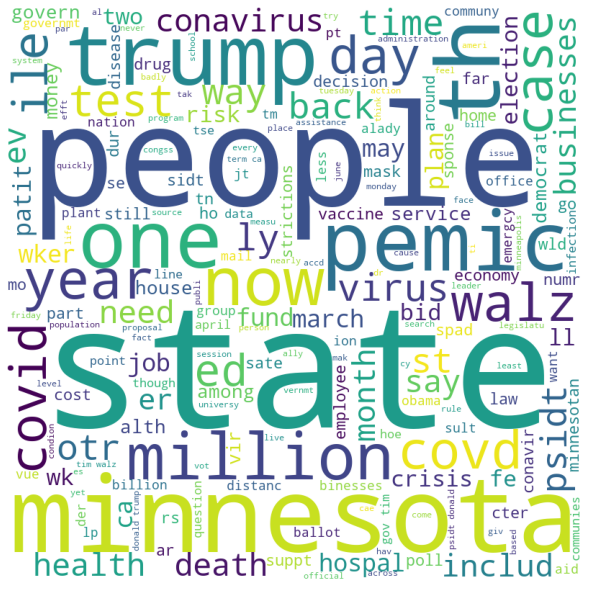

In [72]:
# iterate through the csv file
def displayWordCloud(data,label):
    comment_words = '' 
    stopwords = set(STOPWORDS) 
    for val in data: 

        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        comment_words += " ".join(tokens)+" "
        comment_words = comment_words.replace('wh','')
        comment_words = comment_words.replace('ing','')
        comment_words = comment_words.replace('en','')
        comment_words = comment_words.replace('ich','')
        comment_words = comment_words.replace('tir','')
        comment_words = comment_words.replace('ek','')
        comment_words = comment_words.replace('re','')
        comment_words = comment_words.replace('ty','')
        comment_words = comment_words.replace('wn','')

    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 


    # plot the WordCloud image
    fig = plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()
    fig.savefig(label+'.png')
displayWordCloud(dataS4,'StarTribune - May')

#### Corona cases

In [98]:
total_cases = []
lookup = ['diagnosed','infected','killed','case','cases','death','deaths','died','quarantining','quarantine','quarantined']
for paragraphs in dataS['Report'].tolist():
    cases = []
    for sentence in paragraphs.split('.'):
    #     print(sentence)
        for lookupwords in lookup:
            if lookupwords in sentence:
                for words in sentence.split():
                    words = words.replace(',','')
                    words = words.replace('-plus','')
                    if words.isdigit():
#                         print(words)
                        cases.append(int(words))
                break
#                 print("\n")
    total_cases.append(sum(cases))

In [100]:
len(total_cases)

500

In [101]:
dataS['Corona_Cases_number'] = total_cases

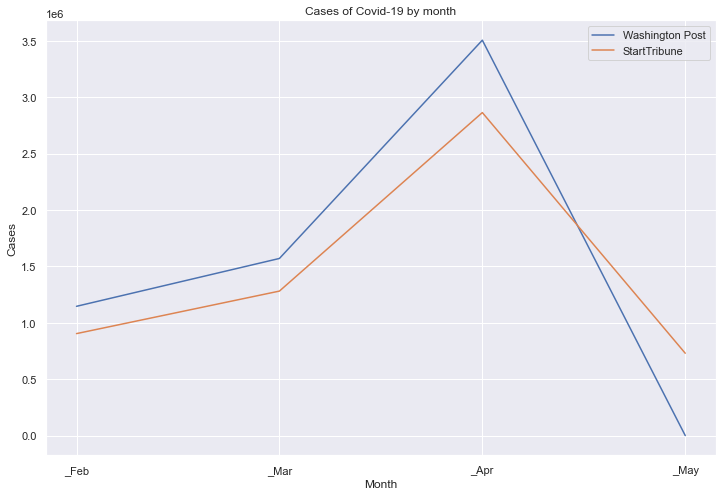

<Figure size 432x288 with 0 Axes>

In [134]:
import matplotlib.pyplot as plt
w1 = ['_Feb','_Mar','_Apr','_May']
w2 = [dataW[(dataW['Corrected_Date']>='2020-02-01') & (dataW['Corrected_Date']<'2020-03-01')]['Corona_Cases_number'].sum(),
             dataW[(dataW['Corrected_Date']>='2020-03-01') & (dataW['Corrected_Date']<'2020-04-01')]['Corona_Cases_number'].sum(),
             dataW[(dataW['Corrected_Date']>='2020-04-01') & (dataW['Corrected_Date']<'2020-05-01')]['Corona_Cases_number'].sum(),
             dataW[(dataW['Corrected_Date']>='2020-05-01') & (dataW['Corrected_Date']<'2020-05-30')]['Corona_Cases_number'].sum()]
s1 = ['_Feb','_Mar','_Apr','_May']
s2 = [dataS[(dataS['Corrected_Date']>='2020-02-01') & (dataS['Corrected_Date']<'2020-03-01')]['Corona_Cases_number'].sum(),
             dataS[(dataS['Corrected_Date']>='2020-03-01') & (dataS['Corrected_Date']<'2020-04-01')]['Corona_Cases_number'].sum(),
             dataS[(dataS['Corrected_Date']>='2020-04-01') & (dataS['Corrected_Date']<'2020-05-01')]['Corona_Cases_number'].sum(),
             dataS[(dataS['Corrected_Date']>='2020-05-01') & (dataS['Corrected_Date']<'2020-05-30')]['Corona_Cases_number'].sum()]
plt.figure(figsize=(12,8))
plt.plot(w1, w2, label = "Washington Post")
plt.plot(s1, s2, label = "StartTribune")
plt.xlabel('Month')
plt.ylabel('Cases')
plt.title('Cases of Covid-19 by month')
plt.legend()

plt.show()
plt.savefig('Corona_Virus_Cases.jpeg',dpi = 300)
# df = pd.DataFrame()
# df['Month']=['Feb','Mar','Apr','May']
# df['Month']=[0,1,2,3]
# df['Value']=[dataW[(dataW['Corrected_Date']>='2020-02-01') & (dataW['Corrected_Date']<'2020-03-01')]['Corona_Cases_number'].sum(),
#              dataW[(dataW['Corrected_Date']>='2020-03-01') & (dataW['Corrected_Date']<'2020-04-01')]['Corona_Cases_number'].sum(),
#              dataW[(dataW['Corrected_Date']>='2020-04-01') & (dataW['Corrected_Date']<'2020-05-01')]['Corona_Cases_number'].sum(),
#              dataW[(dataW['Corrected_Date']>='2020-05-01') & (dataW['Corrected_Date']<'2020-05-30')]['Corona_Cases_number'].sum()]

In [136]:
dataW.to_csv('Cleaned_Washington.csv',index=False)
dataS.to_csv('Cleaned_StarTribune.csv',index=False)

In [3]:
import pandas as pd
dataW= pd.read_csv('Cleaned_Washington.csv')
dataS= pd.read_csv('Cleaned_StarTribune.csv')

In [4]:
dataW

,Unnamed: 0,Date,Link,Newspaper Name,Headline,Report,Corrected_Date,Headline_Sentiment,Body_Sentiment,Headline_Keywords,Body_Keywords,Headline_Topic,Body_Topic,Headline_NER_POS,Body_NER_POS,Corona_Cases_number
0,0,"Feb 1, 2020",https://www.washingtonpost.com/world/coronavir...,The Washington Post,"More than 11,800 people in China have been dia...",The United States announced Friday it would be...,2020-02-01,-0.3400,0.5574,"['China', 'nationals', 'entry', 'U.S.', 'healt...","['China', 'States', 'health', 'United', 'virus...","people, face, know, mask, democratic, return, ...","virus, people, say, week, worker, may, test, c...","{'NER': {'CARDINAL': 'More than 11,800', 'GPE'...","{'NER': {'GPE': 'China', 'DATE': 'up to 14 day...",12092
1,1,"Feb 2, 2020",https://www.washingtonpost.com/world/2020/02/0...,The Washington Post,Early missteps and state secrecy in China prob...,BEIJING — It was almost the Lunar New Year and...,2020-02-02,0.0000,-0.5877,"['state', 'secrecy', 'China', 'missteps', 'cor...","['China', 'Pan', 'people', 'health', 'official...","people, face, know, mask, democratic, return, ...","virus, people, say, week, worker, may, test, c...","{'NER': {'GPE': 'China'}, 'POS': {'JJ': 'Early...","{'NER': {'GPE': 'Washington', 'EVENT': 'the Lu...",14679
2,2,"Feb 3, 2020",https://www.washingtonpost.com/business/econom...,The Washington Post,Virus threatens U.S. companies’ supply of Chin...,The battle to contain the Chinese coronavirus ...,2020-02-03,-0.3818,-0.9264,"['supply', 'companies', 'Chinese', 'U.S.', 'pa...","['China', 'U.S.', 'United', 'parts', 'week', '...","virus, big, deal, company, talk, hit, threaten...","virus, people, say, week, worker, may, test, c...","{'NER': {'GPE': 'U.S.', 'NORP': 'Chinese'}, 'P...","{'NER': {'NORP': 'American', 'GPE': 'China', '...",14314
3,3,"Feb 3, 2020",https://www.washingtonpost.com/world/asia_paci...,The Washington Post,Coronavirus infections predicted to grow expon...,BEIJING — One nation after another is closing ...,2020-02-03,-0.5994,-0.9833,"['infections', 'death', 'China', 'Coronavirus'...","['China', 'coronavirus', 'U.S.', 'people', 'Un...","time, good, airline, political, become, first,...","virus, people, say, week, worker, may, test, c...","{'NER': {'ORDINAL': 'first', 'GPE': 'China'}, ...","{'NER': {'GPE': 'Germany', 'CARDINAL': '2019-n...",17750
4,4,"Feb 3, 2020",https://www.washingtonpost.com/outlook/2020/02...,The Washington Post,Why we should be wary of an aggressive governm...,"As the novel coronavirus has spread, so, too, ...",2020-02-03,-0.1531,-0.9980,"['government', 'response', 'coronavirus']","['health', 'travel', 'people', 'panic', 'quara...","never, enough, coronavirus, response, road, wa...","virus, people, say, week, worker, may, test, c...","{'NER': {}, 'POS': {'WRB': 'Why', 'PRP': 'we',...","{'NER': {'GPE': 'Connecticut', 'CARDINAL': 'On...",4097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,"May 1, 2020",https://www.washingtonpost.com/opinions/the-po...,The Washington Post,The Post’s 2020 endorsements for the D.C. Council,D.C. COUNCIL members in recent years haven’t h...,2020-05-01,0.0000,0.9928,"['Post', 'endorsements', 'D.C.', 'Council']","['Ward', 'council', 'attorney', 'issues', 'ele...","get, could, sander, president, money, biden, k...","say, would, trump, state, make, government, al...","{'NER': {'ORG': 'the D.C. Council', 'DATE': '2...","{'NER': {'ORG': 'Ward 8 council', 'DATE': 'cov...",0
496,496,"May 1, 2020",https://www.washingtonpost.com/local/social-is...,The Washington Post,"With census field operations suspended, govern...","Every ten years, the United States counts its ...",2020-05-01,-0.2960,-0.4310,"['census', 'field', 'operations', 'government']","['data', 'bureau', 'census', 'country', 'elect...","trump, try, pick, count, future, announce, com...","say, would, trump, state, make, government, al...","{'NER': {}, 'POS': {'IN': 'With', 'NN': 'gover...","{'NER': {'DATE': 'more than every 10 years', '...",0
497,

In [149]:
temp_str='<|endoftext|>'.join(dataS['Headline'].tolist())

In [150]:
len(temp_str)

38812

In [151]:
text_file = open("StarTribune-Headline.txt", "w",encoding='utf-8')
n = text_file.write(temp_str)
text_file.close()

### Fixing Date

In [45]:
# dataD = pd.read_csv('Bangladesh - DailyStar.csv')
dataP = pd.read_csv('Bangladesh - Prothom_Alo.csv')

In [46]:
# dataD = dataD[0:25]
dataP = dataP[0:25]

In [47]:
dataP

,Date,Link,Newspaper Name,Headline,Report
0,"18 Mar, 2020",https://en.prothomalo.com/bangladesh/corona-un...,Prothom Alo,Corona unit’ to be set up at each division: Ma...,Health and family welfare minister Zahid Maleq...
1,"18 Mar,2020",https://en.prothomalo.com/corporate/global/ube...,Prothom Alo,"Uber, Lyft suspend pooled rides in US, Canada ...",Uber Technologies Inc and Lyft Inc Tuesday beg...
2,"21 Mar,2020",https://en.prothomalo.com/business/local/coron...,Prothom Alo,Corona slashes hotel occupancy,Coronavirus has hit the hotel business hard in...
3,"21 Mar,2020",https://en.prothomalo.com/opinion/interview/co...,Prothom Alo,Corona cripples tour operators,The tourism industry has been hit hard by the ...
4,"20 Mar,2020",https://en.prothomalo.com/opinion/editorial/no...,Prothom Alo,No need to hoard in corona fear,Our main task at the moment is to try our best...
5,"16 Mar,2020",https://en.prothomalo.com/opinion/love-gives-h...,Prothom Alo,Love gives hope in the time of corona,Gabriel Garcia Marques' novel 'Love in the Tim...
6,"16 Mar,2020",https://en.prothomalo.com/entertainment/hollyw...,Prothom Alo,US box office plunges to lowest level amid cor...,Much of public life in the United States essen...
7,"15 Mar,2020",https://en.prothomalo.com/entertainment/bollyw...,Prothom Alo,Sandeep Aur Pinky Faraar’ postponed due to cor...,The release date of the upcoming Parineeti Cho...
8,"9 Mar,20",https://en.prothomalo.com/bangladesh/padma-bri...,Prothom Alo,Padma Bridge progresses amid corona scare,Thirty-year-old Solaiman Khan is a driver at t...
9,"22 Mar,20",https://en.prothomalo.com/bangladesh/all-shopp...,Prothom Alo,All shopping centres to remain shut from 25 to...,All the shopping complexes and malls across th...


In [48]:
month = ['Feb','Mar','Apr']

corrected_date = []
for d in dataP['Date'].str.split(','):
#     print(d[0])
    for m in month:
        if m in d[0]:
#             print(month.index(m))
#             print(d[0].replace(m,'').strip())
            s = "2020/" + str(month.index(m)+2)+ "/" + d[0].replace(m,'').strip()
            corrected_date.append(s)

In [49]:
dataP['corrected_date'] = corrected_date

In [50]:
dataP

,Date,Link,Newspaper Name,Headline,Report,corrected_date
0,"18 Mar, 2020",https://en.prothomalo.com/bangladesh/corona-un...,Prothom Alo,Corona unit’ to be set up at each division: Ma...,Health and family welfare minister Zahid Maleq...,2020/3/18
1,"18 Mar,2020",https://en.prothomalo.com/corporate/global/ube...,Prothom Alo,"Uber, Lyft suspend pooled rides in US, Canada ...",Uber Technologies Inc and Lyft Inc Tuesday beg...,2020/3/18
2,"21 Mar,2020",https://en.prothomalo.com/business/local/coron...,Prothom Alo,Corona slashes hotel occupancy,Coronavirus has hit the hotel business hard in...,2020/3/21
3,"21 Mar,2020",https://en.prothomalo.com/opinion/interview/co...,Prothom Alo,Corona cripples tour operators,The tourism industry has been hit hard by the ...,2020/3/21
4,"20 Mar,2020",https://en.prothomalo.com/opinion/editorial/no...,Prothom Alo,No need to hoard in corona fear,Our main task at the moment is to try our best...,2020/3/20
5,"16 Mar,2020",https://en.prothomalo.com/opinion/love-gives-h...,Prothom Alo,Love gives hope in the time of corona,Gabriel Garcia Marques' novel 'Love in the Tim...,2020/3/16
6,"16 Mar,2020",https://en.prothomalo.com/entertainment/hollyw...,Prothom Alo,US box office plunges to lowest level amid cor...,Much of public life in the United States essen...,2020/3/16
7,"15 Mar,2020",https://en.prothomalo.com/entertainment/bollyw...,Prothom Alo,Sandeep Aur Pinky Faraar’ postponed due to cor...,The release date of the upcoming Parineeti Cho...,2020/3/15
8,"9 Mar,20",https://en.prothomalo.com/bangladesh/padma-bri...,Prothom Alo,Padma Bridge progresses amid corona scare,Thirty-year-old Solaiman Khan is a driver at t...,2020/3/9
9,"22 Mar,20",https://en.prothomalo.com/bangladesh/all-shopp...,Prothom Alo,All shopping centres to remain shut from 25 to...,All the shopping complexes and malls across th...,2020/3/22


In [51]:
dataP['corrected_date'] = pd.to_datetime(dataP['corrected_date'], format="%Y/%m/%d")

In [75]:
dataD

,Date,Link,Newspaper Name,Headline,Report,corrected_date
0,"31 Mar,2020",https://www.thedailystar.net/coronavirus-deadl...,The Daily Star,Coronavirus pandemic to hit growth in Asia: Wo...,The coronavirus pandemic is expected to sharpl...,2020-03-31
1,"30 Mar, 2020",https://www.thedailystar.net/grammy-winning-us...,The Daily Star,Grammy-winning country music star Joe Diffie d...,"Joe Diffie, a Grammy award-winning country mus...",2020-03-30
2,"31 Mar,2020",https://www.thedailystar.net/sports/cricket/ne...,The Daily Star,Lancashire CC chairman dies from coronavirus,"David Hodgkiss, Lancashire cricket club's chai...",2020-03-31
3,"31 Mar, 2020",https://www.thedailystar.net/backpage/news/zim...,The Daily Star,Zimbabwe begins coronavirus lockdown,Zimbabwean authorities yesterday began enforci...,2020-03-31
4,"30 Mar,2020",https://www.thedailystar.net/sports/bangladesh...,The Daily Star,BCB provides support to women cricketers amid ...,With cricket coming to a standstill due to cor...,2020-03-30
5,"30 Mar,2020",https://www.thedailystar.net/usa-extends-coron...,The Daily Star,Trump extends coronavirus social distancing gu...,Bracing the nation for a death toll that could...,2020-03-30
6,"30 Mar,2020",https://www.thedailystar.net/country/combating...,The Daily Star,Combating coronavirus: BGB donates Tk 12.5cr t...,Border Guard Bangladesh (BGB) donated Tk 12.5 ...,2020-03-30
7,"30 Mar,2020",https://www.thedailystar.net/coronavirus-pande...,The Daily Star,Coronavirus: Owners propose to turn Gazipur re...,Owners of an eco-resort in Gazipur have volunt...,2020-03-30
8,"31 Mar,2020",https://www.thedailystar.net/frontpage/news/im...,The Daily Star,"Import 1,000 ventilators immediately",The government should help private hospitals p...,2020-03-31
9,"31 Mar,2020",https://www.thedailystar.net/coronavirus-deadl...,The Daily Star,Indian police fire tear gas on jobless workers...,Police in western India fired tear gas to disp...,2020-03-31


In [76]:
# Generate word clouds per month
# from wordcloud import WordCloud, STOPWORDS 

nlp = spacy.load("en_core_web_sm")
def removePOS(sentence):
  doc = nlp(sentence)

  for token in doc:
    if token.tag_ == 'VBD' or token.tag_ == 'MD' or token.tag_ == 'PRP' or token.tag_ == 'VB' or token.tag_ == 'CC' or token.tag_ == 'JJ':
      sentence = sentence.replace(token.text,'')
  
  return sentence

comment_words = '' 
stopwords = set(STOPWORDS) 

# DailyStar Mar - Apr
dataD1 = dataD[(dataD['corrected_date']>='2020-03-01') & (dataD['corrected_date']<'2020-04-01')]['Report'].apply(removePOS)

dataD2 = dataD[(dataD['corrected_date']>='2020-04-01') & (dataD['corrected_date']<'2020-04-30')]['Report'].apply(removePOS)

# Prothom Alo Mar - Apr
dataP1 = dataP[(dataP['corrected_date']>='2020-03-01') & (dataP['corrected_date']<'2020-04-01')]['Report'].apply(removePOS)

dataP2 = dataP[(dataP['corrected_date']>='2020-04-01') & (dataP['corrected_date']<'2020-04-30')]['Report'].apply(removePOS)


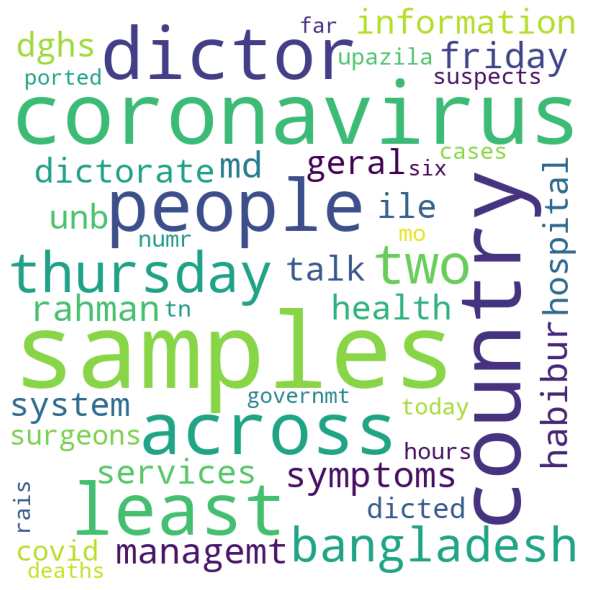

In [80]:
# iterate through the csv file
def displayWordCloud(data,label):
    comment_words = '' 
    stopwords = set(STOPWORDS) 
    for val in data: 

        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        comment_words += " ".join(tokens)+" "
        comment_words = comment_words.replace('wh','')
        comment_words = comment_words.replace('ing','')
        comment_words = comment_words.replace('en','')
        comment_words = comment_words.replace('ich','')
        comment_words = comment_words.replace('tir','')
        comment_words = comment_words.replace('ek','')
        comment_words = comment_words.replace('re','')
        comment_words = comment_words.replace('ty','')
        comment_words = comment_words.replace('wn','')

    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 


    # plot the WordCloud image
    fig = plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()
    fig.savefig(label+'.png')
displayWordCloud(dataP2,'Prothom Alo - Apr')